In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft,ifft,fftfreq
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from scipy import signal
import os

## 0. Data Preprocessing

In [2]:
path = '../data-sets/KDD-Cup/data/'
files_name = [i for i in os.listdir(path) if 'Anomaly' in i] #remove irrelevant files
files_name.sort(key = lambda x : x.split('_')[0]) #sort by id
period = pd.read_csv('../data-sets/KDD-Cup/period/period.csv') #load period file calculated by fourier transform

In [3]:
name = files_name[249]
print("The example data used is :",name)
split_index = int(name.split('.')[0].split('_')[3]) #get split index
data = pd.read_csv(path+name,header=None)
train,test = data[0:split_index],data[split_index::] #split(not use train & test set, just use split index)

The example data used is : 250_UCR_Anomaly_2951.txt


In [4]:
# Normalization
data_mean = train.mean() #record mean
data_std = train.std() #record std
normalized_data = (data - data_mean) / data_std

<Figure size 432x288 with 0 Axes>

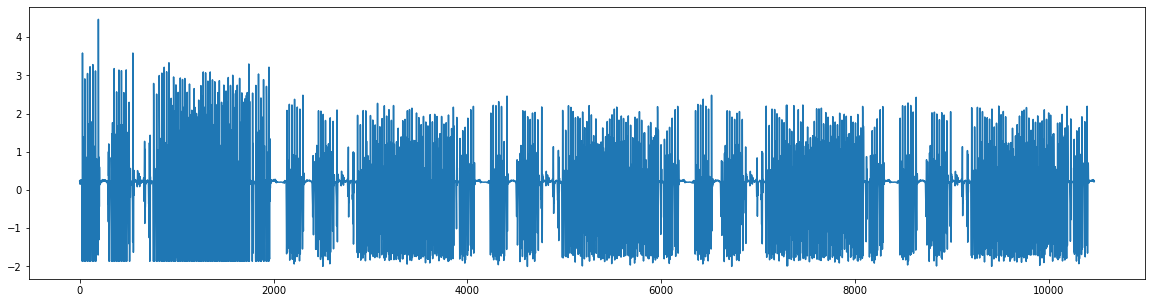

In [5]:
plt.figure(1)
plt.figure(figsize=(20,5))
plt.plot(normalized_data)

In [6]:
TIME_STEPS = int(period[period['File_name'] == name]['Period'])

In [7]:
# INPUT
y = np.array(normalized_data[0])

## 1. Data Forior Transform & Filter
- Filter type:
  - highpass
  - lowpass
  - band

**directly use ft_filter_output() to get the square error for each test points in np.array.**

In [8]:
def ft_filter_output(y,TIME_STEPS,f_type='band',filter_rate = 0.01,order = 8):
    '''
    y: all data input,the whole data sequence.
    f_type: filter type. Choose 'band','highpass','lowpass', recommend 'band' and 'highpass'!
    filter_rate: filter how much signal. For band pass, it will filter 2*filter_rate signal.
    order: use for Butterwoth filter create(阶数)
    '''
    if f_type == 'highpass' or f_type == 'high':
        se = ft_highpass(y,TIME_STEPS,filter_rate,order)
    elif f_type == 'lowpass' or f_type == 'low':
        se = ft_lowpass(y,TIME_STEPS,filter_rate,order)
    elif f_type == 'band':
        se = ft_band(y,TIME_STEPS,filter_rate,order)
    else:
        print('Type is not correct, please check.')
    
    return se

## 2. Low pass filter

### Butterworth

In [9]:
def ft_lowpass(y,TIME_STEPS,filter_rate = 0.01,order = 8):
    '''
    filter_rate: control filter how much signal(default = 1%)
    
    Threshold = n Hz = filter_rate * len
    len = len(y) Hz
    wn = 1 - 2*n/0.01*len(y), filter the highest 1% noise signal
    '''
    b,a = signal.butter(order,1-2*filter_rate*len(y)/len(y),'lowpass') # 8阶
    new = signal.filtfilt(b,a,y)
    point_sse = np.array(np.square(y-new))
    res = point_sse[split_index:-1-TIME_STEPS]
    
    # return the square error of all test data points
    # return type: np.array
    return res

## 3. High pass filter

### Butterworth

In [10]:
def ft_highpass(y,TIME_STEPS,filter_rate = 0.01,order = 8):
    '''
    filter_rate: control filter how much signal(default = 1%)
    
    Threshold = n Hz = filter_rate * len
    len = len(y) Hz
    wn = 2*n/0.01*len(y)
    '''
    b,a = signal.butter(order,2*filter_rate*len(y)/len(y),'highpass') # 8阶
    new = signal.filtfilt(b,a,y)
    point_sse = np.array(np.square(y-new))
    res = point_sse[split_index:-1-TIME_STEPS]
    
    # return the square error of all test data points
    # return type: np.array
    return res

## 4. Band pass filter

### Butterworth

In [11]:
def ft_band(y,TIME_STEPS,filter_rate = 0.01,order = 8):
    '''
    filter_rate: control filter how much signal(default = 1%)
    Cause this is bandpass filter, finally it will filter 2*filter_rate signal.
    
    Threshold = n Hz = filter_rate * len
    len = len(y) Hz
    wn_low = 2*n/0.01*len(y)
    wn_high = 1 - 2*n/0.01*len(y)
    '''
    b,a = signal.butter(order,[2*filter_rate*len(y)/len(y),1-2*filter_rate*len(y)/len(y)],'band') # 8阶
    new = signal.filtfilt(b,a,y)
    point_sse = np.array(np.square(y-new))
    res = point_sse[split_index:-1-TIME_STEPS]
    
    # return the square error of all test data points
    # return type: np.array
    return res

## Result

- lowpass

In [12]:
se = ft_filter_output(y,TIME_STEPS,'lowpass',0.01,8)
ab_idx = np.argmax(se) + split_index
ab_idx

9923

Text(0.5, 1.0, 'Abnormal Testing (Normalized Data)')

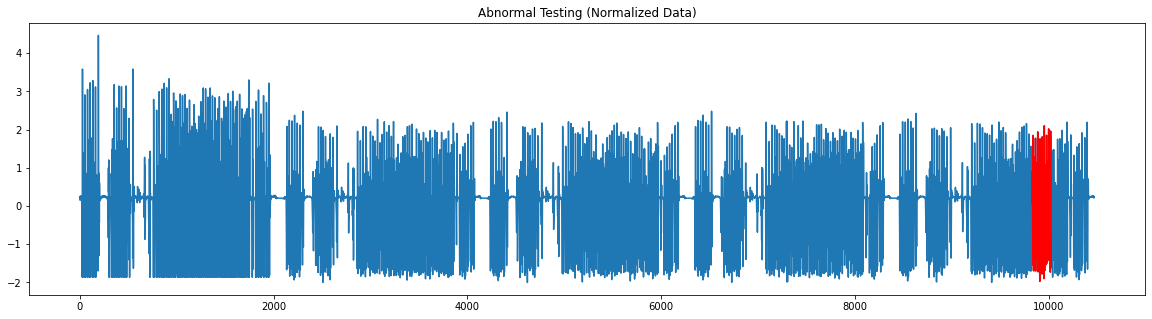

In [13]:
plt.figure(figsize=(20,5))
plt.plot(normalized_data)
plt.plot(normalized_data[ab_idx-100 if ab_idx-100>0 else 0 : ab_idx+100 if ab_idx+100<len(y) else len(y)],'r')
plt.title('Abnormal Testing (Normalized Data)') 

- highpass

In [14]:
se = ft_filter_output(y,TIME_STEPS,'highpass',0.01,8)
ab_idx = np.argmax(se) + split_index
ab_idx

4457

Text(0.5, 1.0, 'Abnormal Testing (Normalized Data)')

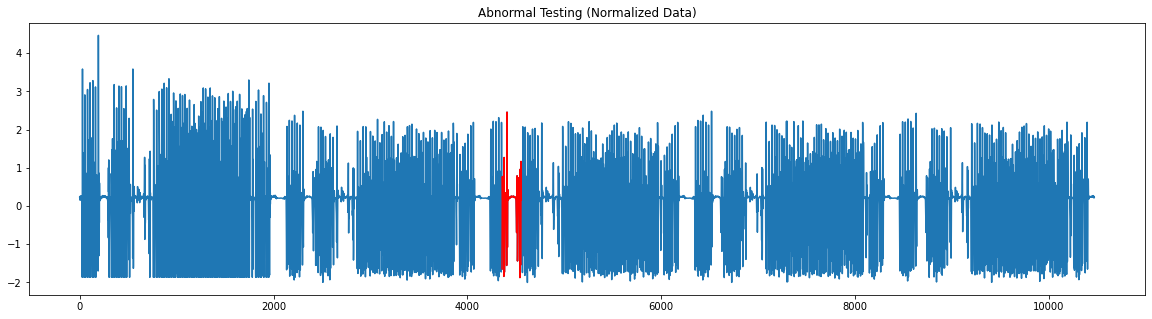

In [15]:
plt.figure(figsize=(20,5))
plt.plot(normalized_data)
plt.plot(normalized_data[ab_idx-100 if ab_idx-100>0 else 0 : ab_idx+100 if ab_idx+100<len(y) else len(y)],'r')
plt.title('Abnormal Testing (Normalized Data)') 

- band

In [16]:
se = ft_filter_output(y,TIME_STEPS,'band',0.01,8)
ab_idx = np.argmax(se) + split_index
ab_idx

4458

Text(0.5, 1.0, 'Abnormal Testing (Normalized Data)')

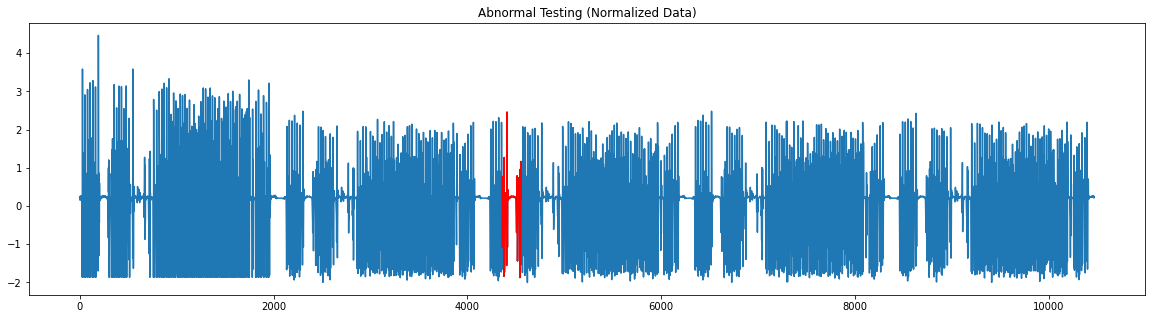

In [17]:
plt.figure(figsize=(20,5))
plt.plot(normalized_data)
plt.plot(normalized_data[ab_idx-100 if ab_idx-100>0 else 0 : ab_idx+100 if ab_idx+100<len(y) else len(y)],'r')
plt.title('Abnormal Testing (Normalized Data)') 